In [14]:
import dpkt, subprocess, shlex, os, glob
import pandas as pd

In [ ]:
def run_command(command):
    process = subprocess.Popen(shlex.split(command), stdout=subprocess.PIPE)
    data = []
    printed = False
    while True:
        output = process.stdout.readline()
        if not printed:
            print(output)
            printed = True
        if output == '' and process.poll() is not None:
            break
        if output:
            data.append(output)
    rc = process.poll()
    return data

In [12]:
filelist = glob.glob('../data/run-aardvark/a-prime/meet/*.pcap')
#cmd = f'tshark -r {fname} -d udp.port=0-50000, rtp -T fields -e frame.time -e ip.src -e ip.dst -e udp.srcport -e udp.dstport -e rtp.seq'
for fname in filelist:
    print(fname)
    outfile = fname[:-4] + "csv"
    cmd = f'tshark -r {fname} -d udp.port==1024-49152,rtp -t e -T fields -e frame.time -e ip.src -e ip.dst -e ip.proto -e udp.srcport -e udp.dstport -e rtp.seq -e frame.len -e rtp.version -e rtp.ssrc -e rtp.cc > {outfile}'
    os.system(cmd)

../data/run-aardvark/a-prime/meet/meet-iperf-1-100-0-0-1618688013.pcap
../data/run-aardvark/a-prime/meet/meet-netflix-0.8-100-0-0-1618693212.pcap
../data/run-aardvark/a-prime/meet/meet-iperf-100-2-0-0-1618688656.pcap
../data/run-aardvark/a-prime/meet/meet-zoom-100-0.8-0-0-1618692542.pcap
../data/run-aardvark/a-prime/meet/meet-meet-100-0.8-0-0-1618687672.pcap
../data/run-aardvark/a-prime/meet/meet-youtube-100-0.8-0-0-1618690897.pcap
../data/run-aardvark/a-prime/meet/meet-youtube-100-1-0-0-1618690578.pcap
../data/run-aardvark/a-prime/meet/meet-iperf-0.8-100-0-0-1618688334.pcap
../data/run-aardvark/a-prime/meet/meet-youtube-2-100-0-0-1618684375.pcap
../data/run-aardvark/a-prime/meet/meet-netflix-2-100-0-0-1618685027.pcap
../data/run-aardvark/a-prime/meet/meet-iperf-100-1-0-0-1618688975.pcap
../data/run-aardvark/a-prime/meet/meet-netflix-1-100-0-0-1618692872.pcap
../data/run-aardvark/a-prime/meet/meet-youtube-1-100-0-0-1618689614.pcap
../data/run-aardvark/a-prime/meet/meet-zoom-1-100-0-0-1

## plot bitrate

In [60]:
from dateutil import parser
from pytz import timezone
import datetime

epoch = datetime.datetime.utcfromtimestamp(0)
tzinfo = timezone('UTC')
epoch = tzinfo.localize(epoch)

def get_timestamp(x):
    dt = parser.parse(x)
    unix_ms = (dt - epoch).total_seconds()
    return unix_ms

In [39]:
col_names = ['frame.time', 'ip.src', 'ip.dst', 'ip.proto', 'udp.srcport', 'udp.dstport', 'rtp.seq', 'frame.len', 'rtp.version', 'rtp.ssrc', 'rtp.cc']
col_map = {i: col_names[i] for i in range(len(col_names))}
fname = "../data/run-aardvark/a/meet/captures/meet-chrome-iperf-0.8-100-0-0-1618688384.csv"
df = pd.read_csv(fname, header=None, delimiter='\t')
df = df.rename(columns=col_map)
df['frame.time'] = df['frame.time'].apply(get_timestamp)
df = df[~pd.isna(df['rtp.seq'])]

/usr/local/anaconda3/envs/TEST/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (3,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [47]:
print(df["ip.src"].value_counts())
print(df["ip.dst"].value_counts())

192.168.1.193    101306
74.125.250.7      10197
Name: ip.src, dtype: int64
74.125.250.7     101306
192.168.1.193     10197
Name: ip.dst, dtype: int64


In [48]:
def get_direction(x):
    if "192.168" in x['ip.src']:
        return "up"
    else:
        return "down"
df["direction"] = df.apply(get_direction, axis=1)  

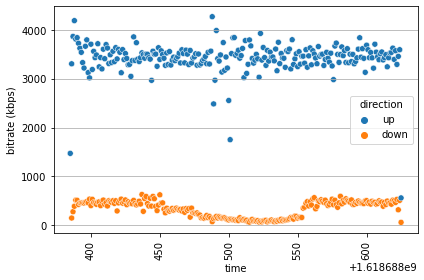

In [49]:
import seaborn as sns, matplotlib.pyplot as plt
# plot bitrate
outfile = None
df["time_s"] = df["frame.time"].apply(lambda x: int(x))
df["frame.len"] = df["frame.len"].apply(lambda x: int(x))
df_grp = df.groupby(["time_s", "direction"]).agg({'frame.len': 'sum'}).reset_index()
df_grp['bitrate_kbps'] = df_grp['frame.len'].apply(lambda x: 8*x/1000) 
sns.scatterplot(x='time_s', y='bitrate_kbps', hue="direction", data=df_grp)# order=df_grp.sort_values('year-month')["year-month"])
plt.xlabel("time")
plt.ylabel("bitrate (kbps)")
plt.grid(axis='y')
plt.xticks(rotation = 90)
plt.tight_layout()
if outfile:
    plt.savefig(outfile)

## One-way delay 

In [67]:
col_names = ['frame.time', 'ip.src', 'ip.dst', 'ip.proto', 'udp.srcport', 'udp.dstport', 'rtp.seq', 'frame.len', 'rtp.version', 'rtp.ssrc', 'rtp.cc']
col_map = {col_names[i]: i for i in range(len(col_names))}

def get_direction_v2(ip_src, pref="192.168"):
    if pref in ip_src:
        return "up"
    else:
        return "down"
    
def read_file(fname):
    content = open(fname).readlines()
    data = []
    for line in content:
        row = line[:-1].split('\t')
        if row[col_map['rtp.seq']] == "":
            continue
        row[col_map['frame.time']] = get_timestamp(row[col_map['frame.time']])
        row.append(get_direction_v2(row[col_map["ip.src"]]))
        data.append(row)
    return data

In [71]:
data1 = read_file(fname)

KeyError: 'rtp.seq'

In [65]:
import operator 
def get_closest_file(dir2, fname):
    ts1 = int(fname.split('-')[-1][:-4])
    filelist= glob.glob(f'{dir2}/*.csv')
    ts_list = []
    for fname2 in filelist:
        ts2 = int(fname2.split('-')[-1][:-4])
        ts_list.append(ts2)
    ts_diff = [abs(ts2 - ts1) for ts2 in ts_list]
    (min_idx, min_val) = min(enumerate(ts_diff), key=operator.itemgetter(1))
    return filelist[min_idx]

data_dir2 = "../data/run-aardvark/a-prime/meet/"
fname2 = get_closest_file(data_dir2, fname)
print(fname2)

../data/run-aardvark/a-prime/meet/meet-iperf-0.8-100-0-0-1618688334.csv


In [69]:
data2 = read_file(fname2)

In [76]:
col_names = ['frame.time', 'ip.src', 'ip.dst', 'ip.proto', 'udp.srcport', 'udp.dstport', 'rtp.seq', 'frame.len', 'rtp.version', 'rtp.ssrc', 'rtp.cc', "direction"]
col_map = {i: col_names[i] for i in range(len(col_names))}
df1 = pd.DataFrame(data1, columns=col_names)
df2 = pd.DataFrame(data2, columns=col_names)
#df1 = df1.rename(columns=col_names)
#df2 = df2.rename(columns=col)
print(df1.shape, df2.shape)

(111503, 12) (27555, 12)


In [79]:
print(df1['rtp.ssrc'].value_counts())
print(df2['rtp.ssrc'].value_counts())

0x2659330d    67292
0x4aa4ebe2    15709
0x5377ba43    11998
0xf80ad61c     9537
0xe94f59c8     5632
0x0170aa72      660
0x6616cb92      360
0xdf92eb11      313
0x71452a3c        2
Name: rtp.ssrc, dtype: int64
0xe94f59c8    18238
0xf80ad61c     5904
0x00001a0c     3279
0x0170aa72       94
0x71452a3c       40
Name: rtp.ssrc, dtype: int64


In [ ]:
col_names = ['frame.time', 'ip.src', 'ip.dst', 'ip.proto', 'udp.srcport', 'udp.dstport', 'rtp.seq', 'frame.len', 'rtp.version', 'rtp.ssrc', 'rtp.cc']
col_map = {i: col_names[i] for i in range(len(col_names))}
fname = "../data/run-aardvark/a/meet/captures/meet-chrome-iperf-0.8-100-0-0-1618688384.csv"
df = pd.read_csv(fname, header=None, delimiter='\t')
df = df.rename(columns=col_map)
df['frame.time'] = df['frame.time'].apply(get_timestamp)
df = df[~pd.isna(df['rtp.seq'])]